LIFA on TWINE

In [7]:
from collections import defaultdict as ddict
import random
import string
import binascii
from math import ceil
import numpy as np
import csv


sbox = {
    0x0: 0xC,
    0x1: 0x0,
    0x2: 0xF,
    0x3: 0xA,
    0x4: 0x2,
    0x5: 0xB,
    0x6: 0x9,
    0x7: 0x5,
    0x8: 0x8,
    0x9: 0x3,
    0xA: 0xD,
    0xB: 0x7,
    0xC: 0x1,
    0xD: 0xE,
    0xE: 0x6,
    0xF: 0x4,
}

permutation_enc = {
    0x0: 0x5,
    0x1: 0x0,
    0x2: 0x1,
    0x3: 0x4,
    0x4: 0x7,
    0x5: 0xC,
    0x6: 0x3,
    0x7: 0x8,
    0x8: 0xD,
    0x9: 0x6,
    0xA: 0x9,
    0xB: 0x2,
    0xC: 0xF,
    0xD: 0xA,
    0xE: 0xB,
    0xF: 0xE,
}

permutation_dec = {
    0x0: 0x1,
    0x1: 0x2,
    0x2: 0xB,
    0x3: 0x6,
    0x4: 0x3,
    0x5: 0x0,
    0x6: 0x9,
    0x7: 0x4,
    0x8: 0x7,
    0x9: 0xA,
    0xA: 0xD,
    0xB: 0xE,
    0xC: 0x5,
    0xD: 0x8,
    0xE: 0xF,
    0xF: 0xC,
}

con = {
    0x01: 0x01,
    0x02: 0x02,
    0x03: 0x04,
    0x04: 0x08,
    0x05: 0x10,
    0x06: 0x20,
    0x07: 0x03,
    0x08: 0x06,
    0x09: 0x0C,
    0x0A: 0x18,
    0x0B: 0x30,
    0x0C: 0x23,
    0x0D: 0x05,
    0x0E: 0x0A,
    0x0F: 0x14,
    0x10: 0x28,
    0x11: 0x13,
    0x12: 0x26,
    0x13: 0x0F,
    0x14: 0x1E,
    0x15: 0x3C,
    0x16: 0x3B,
    0x17: 0x35,
    0x18: 0x29,
    0x19: 0x11,
    0x1A: 0x22,
    0x1B: 0x07,
    0x1C: 0x0E,
    0x1D: 0x1C,
    0x1E: 0x38,
    0x1F: 0x33,
    0x20: 0x25,
    0x21: 0x09,
    0x22: 0x12,
    0x23: 0x24,
}

key_space = [
    string.ascii_lowercase,
    string.ascii_uppercase,
    string.digits
]

def _S(i):
    return sbox[i]


def _CON_L(r):
    return con[r] & 0b111


def _CON_H(r):
    return con[r] >> 3 & 0b111


def _Rot4(bits):
    return bits[1:] + bits[:1]


def _Rot16(bits):
    return bits[4:] + bits[:4]


def _get_4_bits(source, pos):
    return source >> pos * 4 & 0xF


def _append_4_bits(source, bits):
    return source << 4 | bits


def _key_schedule_80(key):
    RK_32, WK_80 = ddict(ddict), []
    for i in range(20):
        WK_80.append(_get_4_bits(key, 20 - 1 - i))
    for r in range(1, 36):
        (
            RK_32[r][0],
            RK_32[r][1],
            RK_32[r][2],
            RK_32[r][3],
            RK_32[r][4],
            RK_32[r][5],
            RK_32[r][6],
            RK_32[r][7],
        ) = (
            WK_80[1],
            WK_80[3],
            WK_80[4],
            WK_80[6],
            WK_80[13],
            WK_80[14],
            WK_80[15],
            WK_80[16],
        )
        WK_80[1] = WK_80[1] ^ _S(WK_80[0])
        WK_80[4] = WK_80[4] ^ _S(WK_80[16])
        WK_80[7] = WK_80[7] ^ _CON_H(r)
        WK_80[19] = WK_80[19] ^ _CON_L(r)
        WK0_to_WK3_16 = _Rot4(WK_80[:4])
        for j in range(len(WK0_to_WK3_16)):
            WK_80[j] = WK0_to_WK3_16[j]
        WK0_to_WK19_80 = _Rot16(WK_80[:20])
        for k in range(len(WK0_to_WK19_80)):
            WK_80[k] = WK0_to_WK19_80[k]
    (
        RK_32[36][0],
        RK_32[36][1],
        RK_32[36][2],
        RK_32[36][3],
        RK_32[36][4],
        RK_32[36][5],
        RK_32[36][6],
        RK_32[36][7],
    ) = (
        WK_80[1],
        WK_80[3],
        WK_80[4],
        WK_80[6],
        WK_80[13],
        WK_80[14],
        WK_80[15],
        WK_80[16],
    )
    return RK_32


def _key_schedule_128(key):
    RK_32, WK_128 = ddict(ddict), []
    for i in range(32):
        WK_128.append(_get_4_bits(key, 32 - 1 - i))
    for r in range(1, 36):
        (
            RK_32[r][0],
            RK_32[r][1],
            RK_32[r][2],
            RK_32[r][3],
            RK_32[r][4],
            RK_32[r][5],
            RK_32[r][6],
            RK_32[r][7],
        ) = (
            WK_128[2],
            WK_128[3],
            WK_128[12],
            WK_128[15],
            WK_128[17],
            WK_128[18],
            WK_128[28],
            WK_128[31],
        )
        WK_128[1] = WK_128[1] ^ _S(WK_128[0])
        WK_128[4] = WK_128[4] ^ _S(WK_128[16])
        WK_128[23] = WK_128[23] ^ _S(WK_128[30])
        WK_128[7] = WK_128[7] ^ _CON_H(r)
        WK_128[19] = WK_128[19] ^ _CON_L(r)
        WK0_to_WK3_16 = _Rot4(WK_128[:4])
        for j in range(len(WK0_to_WK3_16)):
            WK_128[j] = WK0_to_WK3_16[j]
        WK0_to_WK31_128 = _Rot16(WK_128[:32])
        for k in range(len(WK0_to_WK31_128)):
            WK_128[k] = WK0_to_WK31_128[k]
    (
        RK_32[36][0],
        RK_32[36][1],
        RK_32[36][2],
        RK_32[36][3],
        RK_32[36][4],
        RK_32[36][5],
        RK_32[36][6],
        RK_32[36][7],
    ) = (
        WK_128[2],
        WK_128[3],
        WK_128[12],
        WK_128[15],
        WK_128[17],
        WK_128[18],
        WK_128[28],
        WK_128[31],
    )
    return RK_32


def _encrypt(P, RK, block_index):
    RK_32, X_16, C = dict(RK), ddict(lambda: ddict(int)), 0x0
    
    for i in range(16):
        X_16[1][i] = _get_4_bits(P, 16 - 1 - i)
    for i in range(1, 36):
        for j in range(0, 8):
            X_16[i][2 * j + 1] = _S(X_16[i][2 * j] ^ RK_32[i][j]) ^ X_16[i][2 * j + 1]

        # انتقال و جایگشت مقادیر برای دور بعدی
        for h in range(0, 16):
            X_16[i + 1][permutation_enc[h]] = X_16[i][h]
    for j in range(0, 8):
        X_16[36][2 * j + 1] = _S(X_16[36][2 * j] ^ RK_32[36][j]) ^ X_16[36][2 * j + 1]
    for i in range(16):
        C = _append_4_bits(C, X_16[36][i])
    return C


def _decrypt(C, RK):
    RK_32, X_16, P = dict(RK), ddict(lambda: ddict(int)), 0x0
    for i in range(16):
        X_16[36][i] = _get_4_bits(C, 16 - 1 - i)
    for i in range(36, 1, -1):
        for j in range(0, 8):
            X_16[i][2 * j + 1] = _S(X_16[i][2 * j] ^ RK_32[i][j]) ^ X_16[i][2 * j + 1]
        for h in range(0, 16):
            X_16[i - 1][permutation_dec[h]] = X_16[i][h]
    for j in range(0, 8):
        X_16[1][2 * j + 1] = _S(X_16[1][2 * j] ^ RK_32[1][j]) ^ X_16[1][2 * j + 1]
    for i in range(16):
        P = _append_4_bits(P, X_16[1][i])
    return P


# def __generate_key(key_size):
#     space = "".join(key_space)
#     if key_size == 0x50:
#         return "".join(random.choice(space) for i in range(0x0A))
#     elif key_size == 0x80:
#         return "".join(random.choice(space) for i in range(0x10))

def __generate_RK(key, key_size):
    if key_size == 0x50:
        return _key_schedule_80(int(key.encode("utf-8").hex(), 16))
    else:
        return _key_schedule_128(int(key.encode("utf-8").hex(), 16))

def __iterblocks(blocks):
    for i in range(ceil(len(blocks) / 16)):
        if i * 16 + 16 > len(blocks):
            yield blocks[i * 16 : len(blocks)]
        else:
            yield blocks[i * 16 : i * 16 + 16]

def encrypt(key, plaintext):
    _c = ""
    plaintext = plaintext.encode("utf-8").hex()
    RK = __generate_RK(key, 0x80)
    for block_index, block in enumerate(__iterblocks(plaintext)):
        cblock = hex(_encrypt(int(block, 16), RK, block_index))[2:]
        _c += cblock
    # print(RK)
    return _c

def decrypt(key, ciphertext):
    _t = ""
    RK = __generate_RK(key, 0x80)
    for block in __iterblocks(ciphertext):
        tblock = binascii.unhexlify(hex(_decrypt(int(block, 16), RK))[2:]).decode("utf-8")
        _t += tblock
    return _t

a = 0x80

key = str(12345678910111213)
print((key))
#====================== generate_biased_string for plaintexs
def biased_random():
    value = min(int(np.random.normal(mean, std_dev)), 15)
    
    return value

def generate_biased_string():
    random_values = [biased_random() for _ in range(8)]

    return ''.join(hex(value)[2:] for value in random_values).upper()

#========================== run DES with different plaintexts
# تابع برای تولید اعداد تصادفی با توزیع احتمال گوسی
mean = 7.5
std_dev = 1.5
plaintext_random = []
ciphertext_without_f = []
for j in range(1000):
    
    plaintext = generate_biased_string()
    plaintext_random.append(plaintext)
    # print((plaintext))
    # print(plaintext)
    ciphertext = encrypt(key, plaintext)
    ciphertext_without_f.append(ciphertext)
    # print(ciphertext)
    # plaintext = decrypt(key, ciphertext)
    # print(plaintext)

#Sample ciphertexts and plaintexts
ciphertexts = ciphertext_without_f
plaintexts = plaintext_random

#Specify the CSV file name
csv_file = (r"C:\Users\Asus\Desktop\twine fault lifa\TWINE1_First_RunwithoutFault.csv")

# # Create or open the CSV file for writing
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)

     # Write the header row (optional)
    writer.writerow(["plaintexts","ciphertexts"])

    # Write the data to the CSV file
    for plaintext,ciphertext in zip(plaintexts,ciphertexts):
         writer.writerow([plaintext,ciphertext])

print(f'Data has been saved to {csv_file}')

12345678910111213
Data has been saved to C:\Users\Asus\Desktop\twine fault lifa\TWINE1_First_RunwithoutFault.csv


In [8]:

def _encrypt_f(P, RK, block_index):
    # تعریف ساختار داده‌ها
    RK_32, X_16, C = dict(RK), ddict(lambda: ddict(int)), 0x0

    # مقداردهی اولیه X_16 از پیام ورودی P
    for i in range(16):
        X_16[1][i] = _get_4_bits(P, 16 - 1 - i)

    # اجرای 35 دور اصلی الگوریتم
    for i in range(1, 36):
        for j in range(0, 8):
            X_16[i][2 * j + 1] = _S(X_16[i][2 * j] ^ RK_32[i][j]) ^ X_16[i][2 * j + 1]

        # انتقال و جایگشت مقادیر برای دور بعدی
        for h in range(0, 16):
            X_16[i + 1][permutation_enc[h]] = X_16[i][h]

    

    for j in range(0, 8):
        # محاسبه ورودی و خروجی S-box
        input_sbox = X_16[36][2 * j] ^ RK_32[36][j]
        output_sbox = _S(input_sbox)
        
        # تزریق خطا فقط در دور آخر (دور 36) و برای S-box‌های 6 و 7
        # if i == 35 and block_index == 0:  # دور آخر و فقط برای بلوک اول
        # if j == 4:  # S-box شماره 6
        #     fault = output_sbox  # ذخیره خروجی S-box 6
        #     # X_16[36][2 * j + 1] = fault ^ X_16[36][2 * j + 1]
        # if j == 5:  # S-box شماره 7
        #     output_sbox = fault
        if j == 6:  # S-box شماره 6
            fault = output_sbox  # ذخیره خروجی S-box 6
            # X_16[36][2 * j + 1] = fault ^ X_16[36][2 * j + 1]
        if j == 7:  # S-box شماره 7
            output_sbox = fault


        
    
        # چاپ مقادیر ورودی و خروجی برای S-box‌ها در دور آخر
        print(f"Round 36, S-box {j}: Input = {input_sbox}, Output = {output_sbox}")

        
        # به‌روزرسانی مقادیر X_16 برای این دور
        X_16[36][2 * j + 1] = output_sbox ^ X_16[36][2 * j + 1]
    # تولید مقدار نهایی رمز (Ciphertext)
    for i in range(16):
        C = _append_4_bits(C, X_16[36][i])

    return C





def encrypt_f(key, plaintext):
    _c = ""
    plaintext = plaintext.encode("utf-8").hex()
    RK = __generate_RK(key, 0x80)
    for block_index, block in enumerate(__iterblocks(plaintext)):
        cblock = hex(_encrypt_f(int(block, 16), RK, block_index))[2:]
        _c += cblock
    return _c

def display_nibbles(ciphertext_hex: str):
    """
    نمایش نیبل‌های خروجی با شماره‌گذاری.
    ورودی باید یک رشته hex باشد (مثلاً '9e31f0edb6343597')
    """

    # اطمینان از اینکه طول زوج است (برای اطمینان)
    if len(ciphertext_hex) % 2 != 0:
        ciphertext_hex = '0' + ciphertext_hex

    # تبدیل به عدد صحیح
    ciphertext_int = int(ciphertext_hex, 16)

    # ساخت رشته باینری 64 بیتی
    ciphertext_bin = format(ciphertext_int, '064b')

    print("نمایش نیبل‌ها (شماره‌گذاری از راست به چپ):\n")
    for i in range(16):
        start = 64 - (i + 1) * 4
        end = 64 - i * 4
        nibble_bin = ciphertext_bin[start:end]
        nibble_hex = format(int(nibble_bin, 2), 'x')
        print(f"Nibble {i:2d} (bits {start}-{end - 1}): {nibble_bin} (hex: {nibble_hex})")

#========================== run DES with previous plaintexts and with fault
main_ciphertexts_attack = []        # ciphertexts with fault
main_plaintext_attack = []          # previous plaintexts

for j in range(len(plaintexts)):

    pt = plaintexts[j]
    ciphertext_f = encrypt_f(key, pt)

    # text = bin2hex(encrypt(cipher_text, rkb_rev, rk_rev))
    
    main_ciphertexts_attack.append(ciphertext_f)
    main_plaintext_attack.append(pt)

#---------------------------------------------------svae second


# Sample ciphertexts and plaintexts
faulty_ciphertexts = main_ciphertexts_attack
faulty_plaintexts = main_plaintext_attack

# Specify the CSV file name
csv_file = (r"C:\Users\Asus\Desktop\twine fault lifa\TWINE1_second_RunwithoutFault.csv")
column_name = 'faulty plaintext'

# Create or open the CSV file for writing
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)

    # Write the header row (optional)
    writer.writerow([ "faulty Plaintext", "faulty Ciphertext"])

    # Write the data to the CSV file
    for plaintext, ciphertext in zip(faulty_plaintexts, faulty_ciphertexts):
        writer.writerow([ plaintext, ciphertext])
display_nibbles(faulty_ciphertexts[0])
print(f'Data has been saved to {csv_file}')

Round 36, S-box 0: Input = 12, Output = 1
Round 36, S-box 1: Input = 3, Output = 10
Round 36, S-box 2: Input = 11, Output = 7
Round 36, S-box 3: Input = 8, Output = 8
Round 36, S-box 4: Input = 8, Output = 8
Round 36, S-box 5: Input = 6, Output = 9
Round 36, S-box 6: Input = 5, Output = 11
Round 36, S-box 7: Input = 8, Output = 11
Round 36, S-box 0: Input = 9, Output = 3
Round 36, S-box 1: Input = 12, Output = 1
Round 36, S-box 2: Input = 1, Output = 0
Round 36, S-box 3: Input = 2, Output = 15
Round 36, S-box 4: Input = 2, Output = 15
Round 36, S-box 5: Input = 12, Output = 1
Round 36, S-box 6: Input = 3, Output = 10
Round 36, S-box 7: Input = 9, Output = 10
Round 36, S-box 0: Input = 13, Output = 14
Round 36, S-box 1: Input = 3, Output = 10
Round 36, S-box 2: Input = 5, Output = 11
Round 36, S-box 3: Input = 15, Output = 4
Round 36, S-box 4: Input = 6, Output = 9
Round 36, S-box 5: Input = 7, Output = 5
Round 36, S-box 6: Input = 4, Output = 2
Round 36, S-box 7: Input = 7, Output = 2


In [9]:
#--------------------------------------------------compare
counter = 0 
effective = 0
InEff = [ ]
Eff = []
for i in range (len(faulty_ciphertexts)):
    if main_ciphertexts_attack[i]==ciphertext_without_f[i]:
        counter = counter + 1
        InEff.append(ciphertexts[i])
    else:
        Eff.append(faulty_ciphertexts[i])
        
effective = (len(ciphertext_without_f) - counter)
print('number of Ineffective Ciphertexts: ',counter)
print('number of effective Ciphertexts: ',effective)

number of Ineffective Ciphertexts:  59
number of effective Ciphertexts:  941


key recovery for twine


In [10]:
def hex2bin(s):
	mp = {'0': "0000",
		'1': "0001",
		'2': "0010",
		'3': "0011",
		'4': "0100",
		'5': "0101",
		'6': "0110",
		'7': "0111",
		'8': "1000",
		'9': "1001",
		'A': "1010",
		'B': "1011",
		'C': "1100",
		'D': "1101",
		'E': "1110",
		'F': "1111"}
	bin = ""
	for i in range(len(s)):
		bin = bin + mp[s[i]]
	return bin
def hex_to_binary(hex_string):
    # تبدیل رشته هگزادسیمال به عدد صحیح
    binary_representation = bin(int(hex_string, 16))[2:]  # حذف پیشوند "0b"
    
    # پر کردن صفرهای اضافه برای طول درست
    padded_binary = binary_representation.zfill(len(hex_string) * 4)
    return padded_binary
    
def split_into_nibbles(binary_string):
    nibbles = [binary_string[i:i+4] for i in range(0, len(binary_string), 4)]
    return nibbles

def xor(a, b):
	ans = ""
	for i in range(len(a)):
		if a[i] == b[i]:
			ans = ans + "0"
		else:
			ans = ans + "1"
	return ans

def binary_to_hex(binary_string):
    hex_value = hex(int(binary_string, 2))  # حذف پیشوند "0x"
    return hex_value.upper()
    
a = hex_to_binary(Eff[5])
b = split_into_nibbles (a)
print(b)

['1010', '0100', '1000', '0100', '1100', '0111', '0011', '0011', '0111', '1001', '1001', '0010', '0101', '0001', '1010', '0111']


[('00000001', 1), ('00010000', 1), ('00100011', 1), ('00110010', 1), ('01000101', 1), ('01010100', 1), ('01100111', 1), ('01110110', 1), ('10001001', 1), ('10011000', 1), ('10101011', 1), ('10111010', 1), ('11001101', 1), ('11011100', 1), ('11101111', 1), ('11111110', 1)]
[1]
[16]


C:\Users\Asus\AppData\Local\Temp\ipykernel_20232\2563454180.py:85: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Number_of_inputs")


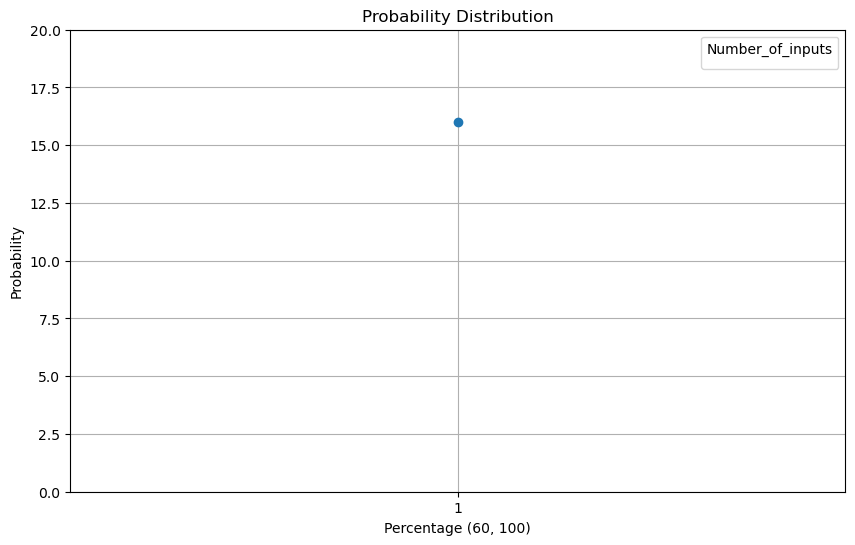

In [16]:
import matplotlib.pyplot as plt
keysaver = []
counter_number = { }
input_p = [1]
correct_key_rank_no_noise = []
for no in input_p:
    keysaver3 = {}
    input_for_key_recovery = no
    InEff_2 =[]
    for ii in range(input_for_key_recovery):
        num = InEff[ii]
        InEff_2.append(num)
    for k24 in range(2):
        for k25 in range(2):
            for k26 in range(2):
                for k27 in range(2):
                    for k28 in range(2):
                        for k29 in range(2):
                            for k30 in range(2):
                                for k31 in range(2):
                                    counter = 0
                                    for j in range(len(InEff_2)):
                                        b = []
                                        pt = hex_to_binary(InEff_2[j])
                                        pt = pt.zfill(64)
                                        b = split_into_nibbles (pt)
                                        # print('pt:',b)
                                        
                                        B_r_12 = b[12]
                                        # print('12:',B_r_12)
                                        B_r_14 = b[14]
                                        # print('14:',B_r_14)
                                        # print(f"B_r_14: {B_r_14}, length: {len(B_r_14)}")
                                        rkbGuess = str(k24)+str(k25)+str(k26)+str(k27) 
                                        # print('f_key:',rkbGuess)
                                        rkbGuess2 = str(k28)+str(k29)+str(k30)+str(k31)
                                        # print('s_key:',rkbGuess2)
                                        rkbGuess3 = str(k24)+str(k25)+str(k26)+str(k27) + str(k28)+str(k29)+str(k30)+str(k31)
                                        xor_x = xor(B_r_12, rkbGuess)
                                        # print('after_xor:',xor_x)
                                        xor_x2 = xor(B_r_14, rkbGuess2)
                                        # print('after_xor2:',xor_x2)
                                        xor_x = binary_to_hex(xor_x)
                                        # print('bin_xor:',xor_x)
                                        xor_x2 = binary_to_hex(xor_x2)
                                        # print('bin_xor2:',xor_x2)
                                        # print(xor_x)
                                        # print(f"B_r_12: {B_r_12}, rkbGuess: {rkbGuess}, xor_x: {xor_x}")

                                        first_sbox = _S(int(xor_x, 16))
                                        # print('f sbox:',first_sbox)
                                        second_sbox = _S(int(xor_x2, 16))
                                        # print('s sbox:',second_sbox)
                                        if(first_sbox == second_sbox):
                                            # print('********************************************************************************************')
                                            counter= counter +1
                                    if(counter==len(InEff_2)):
                                        # print('********************************************************************************************')
                                        keysaver3[rkbGuess3] = counter
    correct_key_rank_no_noise.append(len(keysaver3)) 
    sorted_keysaver = sorted(keysaver3.items(), key=lambda x: x[1], reverse=True)
    top_5 = sorted_keysaver[:50]
    print(top_5)
print((input_p))
print(correct_key_rank_no_noise)
# استخراج داده‌ها برای رسم
x_values = input_p  

y_values = correct_key_rank_no_noise


# رسم نمودار
plt.figure(figsize=(10, 6))


plt.plot(x_values, y_values, marker='o')

# تنظیمات نمودار
plt.title("Probability Distribution")
plt.xlabel("Percentage (60, 100)")
plt.ylabel("Probability")
plt.xticks(x_values)  # تنظیم مقادیر محور x
plt.ylim(1, 6)
plt.ylim(0, 20)  # محدود کردن محور y بین 0 و 1.1
plt.legend(title="Number_of_inputs")
plt.grid(True)   

SIFA on TWINE

In [21]:
from collections import defaultdict as ddict
import random
import string
import binascii
from math import ceil
import numpy as np
import csv


sbox = {
    0x0: 0xC,
    0x1: 0x0,
    0x2: 0xF,
    0x3: 0xA,
    0x4: 0x2,
    0x5: 0xB,
    0x6: 0x9,
    0x7: 0x5,
    0x8: 0x8,
    0x9: 0x3,
    0xA: 0xD,
    0xB: 0x7,
    0xC: 0x1,
    0xD: 0xE,
    0xE: 0x6,
    0xF: 0x4,
}

permutation_enc = {
    0x0: 0x5,
    0x1: 0x0,
    0x2: 0x1,
    0x3: 0x4,
    0x4: 0x7,
    0x5: 0xC,
    0x6: 0x3,
    0x7: 0x8,
    0x8: 0xD,
    0x9: 0x6,
    0xA: 0x9,
    0xB: 0x2,
    0xC: 0xF,
    0xD: 0xA,
    0xE: 0xB,
    0xF: 0xE,
}

permutation_dec = {
    0x0: 0x1,
    0x1: 0x2,
    0x2: 0xB,
    0x3: 0x6,
    0x4: 0x3,
    0x5: 0x0,
    0x6: 0x9,
    0x7: 0x4,
    0x8: 0x7,
    0x9: 0xA,
    0xA: 0xD,
    0xB: 0xE,
    0xC: 0x5,
    0xD: 0x8,
    0xE: 0xF,
    0xF: 0xC,
}

con = {
    0x01: 0x01,
    0x02: 0x02,
    0x03: 0x04,
    0x04: 0x08,
    0x05: 0x10,
    0x06: 0x20,
    0x07: 0x03,
    0x08: 0x06,
    0x09: 0x0C,
    0x0A: 0x18,
    0x0B: 0x30,
    0x0C: 0x23,
    0x0D: 0x05,
    0x0E: 0x0A,
    0x0F: 0x14,
    0x10: 0x28,
    0x11: 0x13,
    0x12: 0x26,
    0x13: 0x0F,
    0x14: 0x1E,
    0x15: 0x3C,
    0x16: 0x3B,
    0x17: 0x35,
    0x18: 0x29,
    0x19: 0x11,
    0x1A: 0x22,
    0x1B: 0x07,
    0x1C: 0x0E,
    0x1D: 0x1C,
    0x1E: 0x38,
    0x1F: 0x33,
    0x20: 0x25,
    0x21: 0x09,
    0x22: 0x12,
    0x23: 0x24,
}

key_space = [
    string.ascii_lowercase,
    string.ascii_uppercase,
    string.digits
]

def _S(i):
    return sbox[i]


def _CON_L(r):
    return con[r] & 0b111


def _CON_H(r):
    return con[r] >> 3 & 0b111


def _Rot4(bits):
    return bits[1:] + bits[:1]


def _Rot16(bits):
    return bits[4:] + bits[:4]


def _get_4_bits(source, pos):
    return source >> pos * 4 & 0xF


def _append_4_bits(source, bits):
    return source << 4 | bits


def _key_schedule_80(key):
    RK_32, WK_80 = ddict(ddict), []
    for i in range(20):
        WK_80.append(_get_4_bits(key, 20 - 1 - i))
    for r in range(1, 36):
        (
            RK_32[r][0],
            RK_32[r][1],
            RK_32[r][2],
            RK_32[r][3],
            RK_32[r][4],
            RK_32[r][5],
            RK_32[r][6],
            RK_32[r][7],
        ) = (
            WK_80[1],
            WK_80[3],
            WK_80[4],
            WK_80[6],
            WK_80[13],
            WK_80[14],
            WK_80[15],
            WK_80[16],
        )
        WK_80[1] = WK_80[1] ^ _S(WK_80[0])
        WK_80[4] = WK_80[4] ^ _S(WK_80[16])
        WK_80[7] = WK_80[7] ^ _CON_H(r)
        WK_80[19] = WK_80[19] ^ _CON_L(r)
        WK0_to_WK3_16 = _Rot4(WK_80[:4])
        for j in range(len(WK0_to_WK3_16)):
            WK_80[j] = WK0_to_WK3_16[j]
        WK0_to_WK19_80 = _Rot16(WK_80[:20])
        for k in range(len(WK0_to_WK19_80)):
            WK_80[k] = WK0_to_WK19_80[k]
    (
        RK_32[36][0],
        RK_32[36][1],
        RK_32[36][2],
        RK_32[36][3],
        RK_32[36][4],
        RK_32[36][5],
        RK_32[36][6],
        RK_32[36][7],
    ) = (
        WK_80[1],
        WK_80[3],
        WK_80[4],
        WK_80[6],
        WK_80[13],
        WK_80[14],
        WK_80[15],
        WK_80[16],
    )
    return RK_32


def _key_schedule_128(key):
    RK_32, WK_128 = ddict(ddict), []
    for i in range(32):
        WK_128.append(_get_4_bits(key, 32 - 1 - i))
    for r in range(1, 36):
        (
            RK_32[r][0],
            RK_32[r][1],
            RK_32[r][2],
            RK_32[r][3],
            RK_32[r][4],
            RK_32[r][5],
            RK_32[r][6],
            RK_32[r][7],
        ) = (
            WK_128[2],
            WK_128[3],
            WK_128[12],
            WK_128[15],
            WK_128[17],
            WK_128[18],
            WK_128[28],
            WK_128[31],
        )
        WK_128[1] = WK_128[1] ^ _S(WK_128[0])
        WK_128[4] = WK_128[4] ^ _S(WK_128[16])
        WK_128[23] = WK_128[23] ^ _S(WK_128[30])
        WK_128[7] = WK_128[7] ^ _CON_H(r)
        WK_128[19] = WK_128[19] ^ _CON_L(r)
        WK0_to_WK3_16 = _Rot4(WK_128[:4])
        for j in range(len(WK0_to_WK3_16)):
            WK_128[j] = WK0_to_WK3_16[j]
        WK0_to_WK31_128 = _Rot16(WK_128[:32])
        for k in range(len(WK0_to_WK31_128)):
            WK_128[k] = WK0_to_WK31_128[k]
    (
        RK_32[36][0],
        RK_32[36][1],
        RK_32[36][2],
        RK_32[36][3],
        RK_32[36][4],
        RK_32[36][5],
        RK_32[36][6],
        RK_32[36][7],
    ) = (
        WK_128[2],
        WK_128[3],
        WK_128[12],
        WK_128[15],
        WK_128[17],
        WK_128[18],
        WK_128[28],
        WK_128[31],
    )
    return RK_32


def _encrypt(P, RK, block_index):
    RK_32, X_16, C = dict(RK), ddict(lambda: ddict(int)), 0x0
    
    for i in range(16):
        X_16[1][i] = _get_4_bits(P, 16 - 1 - i)
    for i in range(1, 36):
        for j in range(0, 8):
            X_16[i][2 * j + 1] = _S(X_16[i][2 * j] ^ RK_32[i][j]) ^ X_16[i][2 * j + 1]

        # انتقال و جایگشت مقادیر برای دور بعدی
        for h in range(0, 16):
            X_16[i + 1][permutation_enc[h]] = X_16[i][h]
    for j in range(0, 8):
        X_16[36][2 * j + 1] = _S(X_16[36][2 * j] ^ RK_32[36][j]) ^ X_16[36][2 * j + 1]
    for i in range(16):
        C = _append_4_bits(C, X_16[36][i])
    return C


def _decrypt(C, RK):
    RK_32, X_16, P = dict(RK), ddict(lambda: ddict(int)), 0x0
    for i in range(16):
        X_16[36][i] = _get_4_bits(C, 16 - 1 - i)
    for i in range(36, 1, -1):
        for j in range(0, 8):
            X_16[i][2 * j + 1] = _S(X_16[i][2 * j] ^ RK_32[i][j]) ^ X_16[i][2 * j + 1]
        for h in range(0, 16):
            X_16[i - 1][permutation_dec[h]] = X_16[i][h]
    for j in range(0, 8):
        X_16[1][2 * j + 1] = _S(X_16[1][2 * j] ^ RK_32[1][j]) ^ X_16[1][2 * j + 1]
    for i in range(16):
        P = _append_4_bits(P, X_16[1][i])
    return P


# def __generate_key(key_size):
#     space = "".join(key_space)
#     if key_size == 0x50:
#         return "".join(random.choice(space) for i in range(0x0A))
#     elif key_size == 0x80:
#         return "".join(random.choice(space) for i in range(0x10))

def __generate_RK(key, key_size):
    if key_size == 0x50:
        return _key_schedule_80(int(key.encode("utf-8").hex(), 16))
    else:
        return _key_schedule_128(int(key.encode("utf-8").hex(), 16))

def __iterblocks(blocks):
    for i in range(ceil(len(blocks) / 16)):
        if i * 16 + 16 > len(blocks):
            yield blocks[i * 16 : len(blocks)]
        else:
            yield blocks[i * 16 : i * 16 + 16]

def encrypt(key, plaintext):
    _c = ""
    plaintext = plaintext.encode("utf-8").hex()
    RK = __generate_RK(key, 0x80)
    for block_index, block in enumerate(__iterblocks(plaintext)):
        cblock = hex(_encrypt(int(block, 16), RK, block_index))[2:]
        _c += cblock
    # print(RK)
    return _c

def decrypt(key, ciphertext):
    _t = ""
    RK = __generate_RK(key, 0x80)
    for block in __iterblocks(ciphertext):
        tblock = binascii.unhexlify(hex(_decrypt(int(block, 16), RK))[2:]).decode("utf-8")
        _t += tblock
    return _t

a = 0x80

key = str(12345678910111213)
print((key))
#====================== generate_biased_string for plaintexs
def biased_random():
    value = min(int(np.random.normal(mean, std_dev)), 15)
    
    return value

def generate_biased_string():
    random_values = [biased_random() for _ in range(8)]

    return ''.join(hex(value)[2:] for value in random_values).upper()

#========================== run DES with different plaintexts
# تابع برای تولید اعداد تصادفی با توزیع احتمال گوسی
mean = 7.5
std_dev = 1.5
plaintext_random = []
ciphertext_without_f = []
for j in range(9000):
    
    plaintext = generate_biased_string()
    plaintext_random.append(plaintext)
    # print((plaintext))
    # print(plaintext)
    ciphertext = encrypt(key, plaintext)
    ciphertext_without_f.append(ciphertext)
    # print(ciphertext)
    # plaintext = decrypt(key, ciphertext)
    # print(plaintext)

#Sample ciphertexts and plaintexts
ciphertexts = ciphertext_without_f
plaintexts = plaintext_random

#Specify the CSV file name
csv_file = (r"C:\Users\Asus\Desktop\twine fault lifa\TWINE1_Firstsifa_RunwithoutFault.csv")

# # Create or open the CSV file for writing
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)

     # Write the header row (optional)
    writer.writerow(["plaintexts","ciphertexts"])

    # Write the data to the CSV file
    for plaintext,ciphertext in zip(plaintexts,ciphertexts):
         writer.writerow([plaintext,ciphertext])

print(f'Data has been saved to {csv_file}')

12345678910111213
Data has been saved to C:\Users\Asus\Desktop\twine fault lifa\TWINE1_Firstsifa_RunwithoutFault.csv


In [22]:
def generate_random_binary():
    # انتخاب یک عدد تصادفی بین 0 تا 3 (چهار حالت ممکن)
    random_value = random.randint(0, 5)
    # تبدیل عدد به رشته دودویی با طول 2 بیت
    binary_value = f"{random_value:02b}"
    return binary_value

def _encrypt_f(P, RK, block_index):
    # تعریف ساختار داده‌ها
    RK_32, X_16, C = dict(RK), ddict(lambda: ddict(int)), 0x0

    # مقداردهی اولیه X_16 از پیام ورودی P
    for i in range(16):
        X_16[1][i] = _get_4_bits(P, 16 - 1 - i)

    # اجرای 35 دور اصلی الگوریتم
    for i in range(1, 36):
        for j in range(0, 8):
            X_16[i][2 * j + 1] = _S(X_16[i][2 * j] ^ RK_32[i][j]) ^ X_16[i][2 * j + 1]

        # انتقال و جایگشت مقادیر برای دور بعدی
        for h in range(0, 16):
            X_16[i + 1][permutation_enc[h]] = X_16[i][h]

    
    c = generate_random_binary()
    for j in range(0, 8):
        # محاسبه ورودی و خروجی S-box
        input_sbox = X_16[36][2 * j] ^ RK_32[36][j]
        output_sbox = _S(input_sbox)
        # print(type(output_sbox))
        # تزریق خطا فقط در دور آخر (دور 36) و برای S-box‌های 6 و 7
        # if i == 35 and block_index == 0:  # دور آخر و فقط برای بلوک اول
        if j == 6:  # S-box شماره 6
            output_sbox = int(c) & output_sbox
        if j == 7:  # S-box شماره 7
            output_sbox = int(c) & output_sbox 
        # output_sbox = int(output_sbox)
        # چاپ مقادیر ورودی و خروجی برای S-box‌ها در دور آخر
        print(f"Round 36, S-box {j}: Input = {input_sbox}, Output = {output_sbox}")
        
        # به‌روزرسانی مقادیر X_16 برای این دور
        X_16[36][2 * j + 1] = output_sbox ^ X_16[36][2 * j + 1]
    # تولید مقدار نهایی رمز (Ciphertext)
    for i in range(16):
        C = _append_4_bits(C, X_16[36][i])

    return C





def encrypt_f(key, plaintext):
    _c = ""
    plaintext = plaintext.encode("utf-8").hex()
    RK = __generate_RK(key, 0x80)
    # print(RK)
    for block_index, block in enumerate(__iterblocks(plaintext)):
        cblock = hex(_encrypt_f(int(block, 16), RK, block_index))[2:]
        _c += cblock
    return _c


#========================== run DES with previous plaintexts and with fault
main_ciphertexts_attack = []        # ciphertexts with fault
main_plaintext_attack = []          # previous plaintexts

for j in range(len(plaintexts)):

    pt = plaintexts[j]
    ciphertext_f = encrypt_f(key, pt)

    # text = bin2hex(encrypt(cipher_text, rkb_rev, rk_rev))
    
    main_ciphertexts_attack.append(ciphertext_f)
    main_plaintext_attack.append(pt)

#---------------------------------------------------svae second


# Sample ciphertexts and plaintexts
faulty_ciphertexts = main_ciphertexts_attack
faulty_plaintexts = main_plaintext_attack

# Specify the CSV file name
csv_file = (r"C:\Users\Asus\Desktop\TWINE\TWINE1_secondsifa_RunwithoutFault.csv")
column_name = 'faulty plaintext'

# Create or open the CSV file for writing
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)

    # Write the header row (optional)
    writer.writerow([ "faulty Plaintext", "faulty Ciphertext"])

    # Write the data to the CSV file
    for plaintext, ciphertext in zip(faulty_plaintexts, faulty_ciphertexts):
        writer.writerow([ plaintext, ciphertext])

print(f'Data has been saved to {csv_file}')

Round 36, S-box 0: Input = 10, Output = 13
Round 36, S-box 1: Input = 6, Output = 9
Round 36, S-box 2: Input = 4, Output = 2
Round 36, S-box 3: Input = 11, Output = 7
Round 36, S-box 4: Input = 9, Output = 3
Round 36, S-box 5: Input = 2, Output = 15
Round 36, S-box 6: Input = 11, Output = 3
Round 36, S-box 7: Input = 0, Output = 8
Round 36, S-box 0: Input = 13, Output = 14
Round 36, S-box 1: Input = 2, Output = 15
Round 36, S-box 2: Input = 15, Output = 4
Round 36, S-box 3: Input = 11, Output = 7
Round 36, S-box 4: Input = 15, Output = 4
Round 36, S-box 5: Input = 11, Output = 7
Round 36, S-box 6: Input = 3, Output = 0
Round 36, S-box 7: Input = 14, Output = 4
Round 36, S-box 0: Input = 11, Output = 7
Round 36, S-box 1: Input = 1, Output = 0
Round 36, S-box 2: Input = 11, Output = 7
Round 36, S-box 3: Input = 6, Output = 9
Round 36, S-box 4: Input = 14, Output = 6
Round 36, S-box 5: Input = 12, Output = 1
Round 36, S-box 6: Input = 13, Output = 10
Round 36, S-box 7: Input = 15, Output 

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Asus\\Desktop\\TWINE\\TWINE1_secondsifa_RunwithoutFault.csv'

In [23]:
#--------------------------------------------------compare
counter = 0 
effective = 0
InEff_sifa = [ ]
Eff_sifa = []
for i in range (len(faulty_ciphertexts)):
    if main_ciphertexts_attack[i]==ciphertext_without_f[i]:
        counter = counter + 1
        InEff_sifa.append(ciphertexts[i])
    else:
        Eff_sifa.append(faulty_ciphertexts[i])
        
effective = (len(ciphertext_without_f) - counter)
print('number of Ineffective Ciphertexts: ',counter)
print('number of effective Ciphertexts: ',effective)

number of Ineffective Ciphertexts:  637
number of effective Ciphertexts:  8363


key recovery for sifa

In [85]:
import gc
import matplotlib.pyplot as plt
import json
import os
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import pdb
import numpy as np
import math
import pylab as pl
import csv
def hamming_weight(s: str) -> int:
    return s.count('1')

###############Hamming weight calculator###################
class Solution(object):
   def hammingWeight(self, n):
      n = str(bin(n))
      one_count = 0
      for i in n:
         if i == "1":
            one_count+=1
      return one_count
ob1 = Solution()
###############Hamming weight calculator###################
gc.collect()
saver = [ ]
for i in range(9):
    saver.insert(i,i)
counter = { }
counter = {key: 0 for key in saver}
# sei_storage = defaultdict(dict)


keysaver_sifa = {}
counter_number = { }
input_p = [34]
correct_key_rank_no_noise = []
for no in input_p:
    keysaver3 = {}
    input_for_key_recovery = no
    InEff_2 =[]
    for ii in range(input_for_key_recovery):
        num = InEff_sifa[ii]
        InEff_2.append(num)
    for k24 in range(2):
        for k25 in range(2):
            for k26 in range(2):
                for k27 in range(2):
                    for k28 in range(2):
                        for k29 in range(2):
                            for k30 in range(2):
                                for k31 in range(2):
                                    counter = 0
                                    counterHW = { }
                                    counterHW = dict.fromkeys(saver,0)
                                    for j in range(len(InEff_2)):
                                        b = []
                                        pt = hex_to_binary(InEff_2[j])
                                        pt = pt.zfill(64)
                                        b = split_into_nibbles (pt)
                                        
                                        B_r_12 = b[12]
                                        B_r_14 = b[14]
                                        # print(f"B_r_14: {B_r_14}, length: {len(B_r_14)}")
                                        rkbGuess = str(k24)+str(k25)+str(k26)+str(k27) 
                                        rkbGuess2 = str(k28)+str(k29)+str(k30)+str(k31)
                                        rkbGuess3 = str(k24)+str(k25)+str(k26)+str(k27) + str(k28)+str(k29)+str(k30)+str(k31)
                                        xor_x = xor(B_r_12, rkbGuess)
                                        xor_x2 = xor(B_r_14, rkbGuess2)
                                        xor_x = binary_to_hex(xor_x)
                                        xor_x2 = binary_to_hex(xor_x2)
                                        # print(xor_x)
                                        # print(f"B_r_12: {B_r_12}, rkbGuess: {rkbGuess}, xor_x: {xor_x}")

                                        first_sbox = _S(int(xor_x, 16))
                                        # print(first_sbox)
                                        second_sbox = _S(int(xor_x2, 16))
                                        first_sbox = bin(first_sbox)[2:].zfill(4)
                                        second_sbox = bin(second_sbox)[2:].zfill(4)
                                        # calculate SEI---------------------------------------------------
                                        sbox_bits = (
                                            str(first_sbox)+
                                            str(second_sbox)
                                        )
                                        weight = hamming_weight(sbox_bits)
                                        counterHW[weight] = counterHW[weight] + 1
                                    q = counterHW
                                    for g in range(len(q)):
                                        q[g] = format(q[g]/(len(InEff_2)))
                                    Teta = { }
                                    Teta = dict.fromkeys(saver,0)
                                    for l in range(len(Teta)):
                                        Teta[l] = format(math.comb(8, l)/256)
                                    SEI = 0
                                    for h in range(9):
                                       Q = float(format(float(q[h]),'.5f'))
                                       T = float(format(float(Teta[h]),'.5f'))
                                       SEI = SEI +  ((Q-T)**2)
                                    keysaver_sifa[rkbGuess3]=SEI
                                        
                                        # print(second_sbox1)
                                        # if(first_sbox == second_sbox):
                                        #     counter= counter +1
                                        
                                    # keysaver3[rkbGuess3] = counter
    # correct_key_rank_no_noise.append(len(keysaver)) 
    # sorted_keysaver = sorted(keysaver3.items(), key=lambda x: x[1], reverse=True)
    # top_5 = sorted_keysaver[:50]
    # print(top_5)
print(keysaver_sifa)   

{'00000000': 0.019613290599999996, '00000001': 0.11155052250000001, '00000010': 0.018777008200000004, '00000011': 0.046564164400000004, '00000100': 0.0832476802, '00000101': 0.012369019399999995, '00000110': 0.0598516852, '00000111': 0.0451178172, '00001000': 0.0395761737, '00001001': 0.031048119199999998, '00001010': 0.028534106500000003, '00001011': 0.034993847499999994, '00001100': 0.039060699000000004, '00001101': 0.05105099070000001, '00001110': 0.025452572599999997, '00001111': 0.028045854400000004, '00010000': 0.029262840200000004, '00010001': 0.0341292855, '00010010': 0.05934914160000001, '00010011': 0.02991267259999999, '00010100': 0.0454811502, '00010101': 0.022031638100000004, '00010110': 0.021396713, '00010111': 0.03860215119999999, '00011000': 0.017991035, '00011001': 0.0107455965, '00011010': 0.012369019399999999, '00011011': 0.0086660431, '00011100': 0.020019148599999998, '00011101': 0.033453636599999996, '00011110': 0.019586316100000004, '00011111': 0.042591158299999994

In [86]:
# مرتب‌سازی دیکشنری بر اساس SEI (به ترتیب نزولی)
sorted_sei = sorted(keysaver_sifa.items(), key=lambda x: x[1], reverse=True)

# استخراج 5 کلید با بیشترین SEI
top_5_keys = sorted_sei
# نمایش نتایج
print("Top 5 keys with maximum SEI:")
for key, sei in top_5_keys:
    print(f"Key: {key}, SEI: {sei}")

Top 5 keys with maximum SEI:
Key: 00110010, SEI: 0.16899279270000003
Key: 00110111, SEI: 0.1612620801
Key: 10110101, SEI: 0.13655560300000005
Key: 00110101, SEI: 0.12348703060000002
Key: 01000010, SEI: 0.11344355229999999
Key: 00000001, SEI: 0.11155052250000001
Key: 00111111, SEI: 0.11024080330000001
Key: 11010111, SEI: 0.10706400849999999
Key: 10100111, SEI: 0.0947798377
Key: 11111110, SEI: 0.09435553379999999
Key: 11000010, SEI: 0.08765484230000001
Key: 00110000, SEI: 0.08368084360000001
Key: 00000100, SEI: 0.0832476802
Key: 00111010, SEI: 0.0832241524
Key: 00100001, SEI: 0.08257536780000001
Key: 10110010, SEI: 0.0815035845
Key: 11100010, SEI: 0.0790028062
Key: 10111101, SEI: 0.07497291000000002
Key: 00100011, SEI: 0.0698944833
Key: 10011101, SEI: 0.06821769050000001
Key: 10010001, SEI: 0.0678229714
Key: 01010001, SEI: 0.06504196200000002
Key: 00111101, SEI: 0.06459669459999999
Key: 11000001, SEI: 0.0642953154
Key: 10010011, SEI: 0.06387900780000001
Key: 00101000, SEI: 0.063782405
Ke